In [224]:
import pandas as pd
import seaborn as sns
import re

In [225]:
df_whole = pd.read_csv('../data/processed/02_cleaned_data.csv', index_col=0)

In [226]:
df_whole.shape

(974, 836)

In [227]:
df_whole.head()

,AP1. Wie alt sind Sie?,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_10.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,AP1. Wie alt sind Sie?_7.0,...,W7[SQ004]. Welche Form von Vergütung erhalten Sie? [Weihnachtsgeld],W7[SQ005]. Welche Form von Vergütung erhalten Sie? [Urlaubsgeld],W7[SQ006]. Welche Form von Vergütung erhalten Sie? [Sachwerte],W8[SQ001]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Arbeitszeitausgleich],W8[SQ002]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Bezahlung],W8[SQ003]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Sachwerte],W8[SQ004]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Gar nicht],W9. Bekommen Sie Ihre Vergütung pünktlich zum vertraglich vereinbarten Zeitpunkt?_1,W9. Bekommen Sie Ihre Vergütung pünktlich zum vertraglich vereinbarten Zeitpunkt?_Teils,id. Antwort ID
0,2.0,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,953
1,2.0,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,24
2,4.0,False,False,False,False,False,True,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,57
3,2.0,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,65
4,2.0,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,93


# Correlation Analysis

In [228]:
# Calculate the correlation matrix
corr_matrix = df_whole.corr(method='pearson')

# Gather unique pairs of correlations
correlations = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):  # Start from i+1 to avoid duplicates and self-correlations
        correlations.append([corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]])

# Create a DataFrame to hold the correlations
corr_df = pd.DataFrame(correlations, columns=['Column1', 'Column2', 'CorrelationCoefficient'])

print(corr_df)

                                                  Column1  \
0                                  AP1. Wie alt sind Sie?   
1                                  AP1. Wie alt sind Sie?   
2                                  AP1. Wie alt sind Sie?   
3                                  AP1. Wie alt sind Sie?   
4                                  AP1. Wie alt sind Sie?   
...                                                   ...   
349025  W8[SQ004]. Wie werden zusätzlich geleistete Ar...   
349026  W8[SQ004]. Wie werden zusätzlich geleistete Ar...   
349027  W9. Bekommen Sie Ihre Vergütung pünktlich zum ...   
349028  W9. Bekommen Sie Ihre Vergütung pünktlich zum ...   
349029  W9. Bekommen Sie Ihre Vergütung pünktlich zum ...   

                                                  Column2  \
0                              AP1. Wie alt sind Sie?_0.0   
1                              AP1. Wie alt sind Sie?_1.0   
2                             AP1. Wie alt sind Sie?_10.0   
3                      

In [229]:
print(corr_df.head())
len(corr_df)

                  Column1                      Column2  CorrelationCoefficient
0  AP1. Wie alt sind Sie?   AP1. Wie alt sind Sie?_0.0               -0.171088
1  AP1. Wie alt sind Sie?   AP1. Wie alt sind Sie?_1.0               -0.439317
2  AP1. Wie alt sind Sie?  AP1. Wie alt sind Sie?_10.0                0.238574
3  AP1. Wie alt sind Sie?   AP1. Wie alt sind Sie?_2.0               -0.456176
4  AP1. Wie alt sind Sie?   AP1. Wie alt sind Sie?_3.0               -0.120672


349030

In [230]:
corr_df_sorted = corr_df.sort_values(by='CorrelationCoefficient')

In [231]:
significant_corr_df =  corr_df[(corr_df['CorrelationCoefficient']>0.7) | (corr_df['CorrelationCoefficient']<-0.7)]
len(significant_corr_df)

549

In [232]:
significant_corr_df.to_csv('../data/processed/03_significant_correlations.csv')
corr_df.to_csv('../data/processed/03_all_correlations.csv')

# visualizations

In [233]:
significant_corr_df.iloc[0][1]

/tmp/ipykernel_18666/2159218889.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  significant_corr_df.iloc[0][1]


'AP5r[SQ002]. Bitte machen Sie folgende Angaben:\xa0 [In wie vielen Berufsjahren insgesamt (Jahre in Ziffern)? ]'

/tmp/ipykernel_18666/1352033493.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x=significant_corr_df.iloc[0][0],
/tmp/ipykernel_18666/1352033493.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=significant_corr_df.iloc[0][1],


<Axes: xlabel='AP1. Wie alt sind Sie?', ylabel='AP5r[SQ002]. Bitte machen Sie folgende Angaben:\xa0 [In wie vielen Berufsjahren insgesamt (Jahre in Ziffern)? ]'>

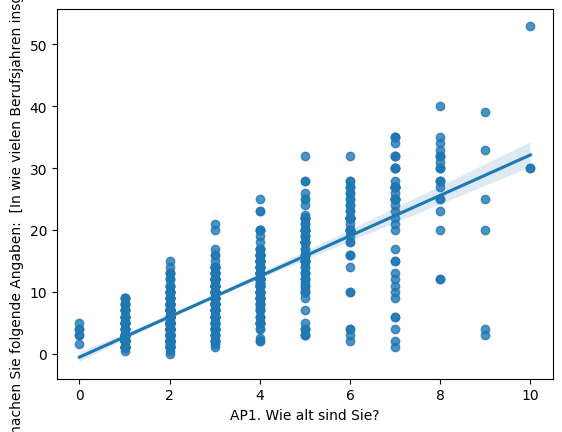

In [234]:
sns.regplot(data=df_whole, 
            x=significant_corr_df.iloc[0][0], 
            y=significant_corr_df.iloc[0][1],
            ci=95)

## fixed term vs permanent contracts Museum

In [235]:
#extract columns with education levels
ls_cols_education_level = [col for col in df_whole if col.startswith('AP2[')]
ls_cols_contract = [col for col in df_whole if col.startswith('M9.')]

#extract education levels
# Regular expression to find a string inside square brackets at the end of column
pattern = re.compile(r'\[([^\]]*)\]$')
strings_inside_brackets = [pattern.search(col).group(1) if pattern.search(col) else None for col in ls_cols_education_level]
print(strings_inside_brackets)

['Bachelor of Arts: ', 'Master of Arts:', 'Magister Artium:', 'I. Staatsexamen:', 'II. Staatsexamen:', 'Diplom:', 'Dr. phil.:', 'Dr. phil. habil. bzw. PD:', 'Sonstiges:', 'Ausländischer akademischer Grad:']


In [236]:
#extract Museumsmitarbeiter and extract the important columns
df_museum = df_whole[df_whole['AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.\xa0  Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen:\xa0_Museums- oder Ausstellungswesen und Denkmalpflege']==True]
df_museum_contract_education = df_museum[ls_cols_education_level + ls_cols_contract]

In [237]:
#create filter for those entries that answered True or False in both questions M9 (fixed term or permanent contract)
df_museum_contract_education['M9_XOR'] = (df_museum_contract_education['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] | df_museum_contract_education['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.']) & ~(df_museum_contract_education['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] & df_museum_contract_education['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])
df_museum_contract_education.head()

/tmp/ipykernel_18666/497052900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_museum_contract_education['M9_XOR'] = (df_museum_contract_education['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] | df_museum_contract_education['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.']) & ~(df_museum_contract_education['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] & df_museum_contract_education['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])


,AP2[SQ001]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Bachelor of Arts: ],AP2[SQ002]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Master of Arts:],AP2[SQ003]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Magister Artium:],AP2[SQ004]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [I. Staatsexamen:],AP2[SQ005]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [II. Staatsexamen:],AP2[SQ006]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Diplom:],AP2[SQ007]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Dr. phil.:],AP2[SQ008]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Dr. phil. habil. bzw. PD:],AP2[SQ009]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Sonstiges:],AP2[SQ010]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Ausländischer akademischer Grad:],M9. Sind Sie momentan befristet beschäftigt? _1,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.",M9_XOR
0,0,1,0,0,0,0,0,0,0,0,True,False,True
1,0,1,0,0,0,0,0,0,0,0,True,False,True
3,0,1,0,0,0,0,0,0,0,0,True,False,True
5,0,0,0,0,0,0,1,0,0,0,False,False,False
15,0,1,0,0,0,0,0,0,0,0,True,False,True


In [238]:
#filter out entries
df_museum_contract_education_filtered = df_museum_contract_education[df_museum_contract_education['M9_XOR']==True]
df_museum_contract_education_filtered.shape

(397, 13)

In [239]:
df_museum_contract_education_filtered

,AP2[SQ001]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Bachelor of Arts: ],AP2[SQ002]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Master of Arts:],AP2[SQ003]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Magister Artium:],AP2[SQ004]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [I. Staatsexamen:],AP2[SQ005]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [II. Staatsexamen:],AP2[SQ006]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Diplom:],AP2[SQ007]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Dr. phil.:],AP2[SQ008]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Dr. phil. habil. bzw. PD:],AP2[SQ009]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Sonstiges:],AP2[SQ010]. Welchen akademischen Grad haben Sie als letztes in welchem Jahr erworben? [Ausländischer akademischer Grad:],M9. Sind Sie momentan befristet beschäftigt? _1,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.",M9_XOR
0,0,1,0,0,0,0,0,0,0,0,True,False,True
1,0,1,0,0,0,0,0,0,0,0,True,False,True
3,0,1,0,0,0,0,0,0,0,0,True,False,True
15,0,1,0,0,0,0,0,0,0,0,True,False,True
16,0,0,0,0,0,0,1,0,0,0,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,0,0,1,0,0,0,0,0,0,0,True,False,True
1002,1,1,0,0,0,0,0,0,0,0,False,True,True
1004,0,0,1,0,0,0,1,0,0,0,False,True,True
1009,0,0,0,0,0,0,1,0,0,0,True,False,True


#### create a new dataframe with aggregated data

In [240]:
# List to hold the data for the new DataFrame
data_for_new_df = []

# Education levels
education_levels = ls_cols_education_level

# Calculate sums for each education level
for level in education_levels:
    fixed_term_sum = df_museum_contract_education_filtered[(df_museum_contract_education_filtered[level]) & (df_museum_contract_education_filtered['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'])].shape[0]
    permanent_sum = df_museum_contract_education_filtered[(df_museum_contract_education_filtered[level]) & (df_museum_contract_education_filtered['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])].shape[0]
    
    data_for_new_df.append({
        'EducationLevel': level,
        'FixedTermSum': fixed_term_sum,
        'PermanentSum': permanent_sum
    })

# Convert the list of dictionaries to a DataFrame
df_edu_level_vs_contracts = pd.DataFrame(data_for_new_df)
df_edu_level_vs_contracts['EducationLevel'] = strings_inside_brackets

df_edu_level_vs_contracts

,EducationLevel,FixedTermSum,PermanentSum
0,Bachelor of Arts:,41,12
1,Master of Arts:,129,46
2,Magister Artium:,40,58
3,I. Staatsexamen:,1,1
4,II. Staatsexamen:,0,1
5,Diplom:,3,2
6,Dr. phil.:,49,70
7,Dr. phil. habil. bzw. PD:,2,1
8,Sonstiges:,4,4
9,Ausländischer akademischer Grad:,1,3


##### add new columns

In [241]:
df_edu_level_vs_contracts['totals'] = df_edu_level_vs_contracts['FixedTermSum'] + df_edu_level_vs_contracts['PermanentSum']
df_edu_level_vs_contracts['FixedTermPerc'] = (df_edu_level_vs_contracts['FixedTermSum'] / (df_edu_level_vs_contracts['FixedTermSum'] + df_edu_level_vs_contracts['PermanentSum']))*100 
df_edu_level_vs_contracts['PermanentPerc'] = (df_edu_level_vs_contracts['PermanentSum'] / (df_edu_level_vs_contracts['FixedTermSum'] + df_edu_level_vs_contracts['PermanentSum']))*100 
df_edu_level_vs_contracts

,EducationLevel,FixedTermSum,PermanentSum,totals,FixedTermPerc,PermanentPerc
0,Bachelor of Arts:,41,12,53,77.358491,22.641509
1,Master of Arts:,129,46,175,73.714286,26.285714
2,Magister Artium:,40,58,98,40.816327,59.183673
3,I. Staatsexamen:,1,1,2,50.000000,50.000000
4,II. Staatsexamen:,0,1,1,0.000000,100.000000
5,Diplom:,3,2,5,60.000000,40.000000
6,Dr. phil.:,49,70,119,41.176471,58.823529
7,Dr. phil. habil. bzw. PD:,2,1,3,66.666667,33.333333
8,Sonstiges:,4,4,8,50.000000,50.000000
9,Ausländischer akademischer Grad:,1,3,4,25.000000,75.000000


Text(1.02, 0.985, 'Gesamtzahl')

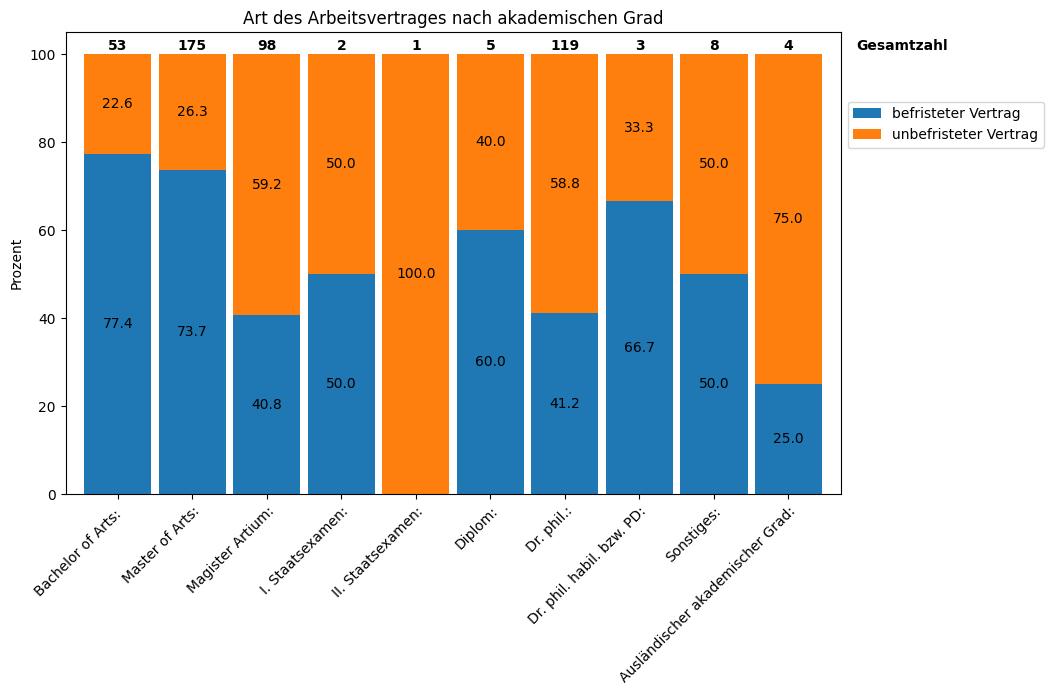

In [242]:
ax = df_edu_level_vs_contracts[['EducationLevel', 'FixedTermPerc', 'PermanentPerc']].set_index('EducationLevel').plot(kind='bar', 
                                                                                          stacked=True, 
                                                                                          figsize=(10, 6),                                                                                        
                                                                                          rot=45,
                                                                                          ylabel='Prozent',
                                                                                          width=0.9,
                                                                                          title='Art des Arbeitsvertrages nach akademischen Grad'
                                                                                          )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(df_edu_level_vs_contracts['EducationLevel'], rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), labels=['befristeter Vertrag', 'unbefristeter Vertrag'])
ax.set_xlabel(None)
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(df_edu_level_vs_contracts['totals']):
    ax.text(df_edu_level_vs_contracts['totals'].index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')
    

In [243]:
fig = ax.get_figure()
fig.savefig('../reports/figures/M_00_Abschluss_vs_Arbeitsvertrag.png', bbox_inches='tight', dpi=300)

### fixed term or permanent contracts by age group

In [244]:
df_museum

,AP1. Wie alt sind Sie?,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_10.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,AP1. Wie alt sind Sie?_7.0,...,W7[SQ004]. Welche Form von Vergütung erhalten Sie? [Weihnachtsgeld],W7[SQ005]. Welche Form von Vergütung erhalten Sie? [Urlaubsgeld],W7[SQ006]. Welche Form von Vergütung erhalten Sie? [Sachwerte],W8[SQ001]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Arbeitszeitausgleich],W8[SQ002]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Bezahlung],W8[SQ003]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Sachwerte],W8[SQ004]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Gar nicht],W9. Bekommen Sie Ihre Vergütung pünktlich zum vertraglich vereinbarten Zeitpunkt?_1,W9. Bekommen Sie Ihre Vergütung pünktlich zum vertraglich vereinbarten Zeitpunkt?_Teils,id. Antwort ID
0,2.0,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,953
1,2.0,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,24
3,2.0,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,65
5,10.0,False,False,True,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,94
15,1.0,False,True,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,6.0,False,False,False,False,False,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,470
1002,4.0,False,False,False,False,False,True,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,510
1004,3.0,False,False,False,False,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,899
1009,3.0,False,False,False,False,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1090


In [245]:
ls_cols_age_level = [col for col in df_whole if col.startswith('AP1.') & col.endswith('.0')]
#the order of age levels needs to be sorted by hand, since age level 10 is not placed at the end of list
order = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 2]
ls_cols_age_level = [ls_cols_age_level[i] for i in order]
df_museum_contract_age = df_museum[ls_cols_age_level + ls_cols_contract]

In [246]:
ls_cols_age_level

['AP1. Wie alt sind Sie?_0.0',
 'AP1. Wie alt sind Sie?_1.0',
 'AP1. Wie alt sind Sie?_2.0',
 'AP1. Wie alt sind Sie?_3.0',
 'AP1. Wie alt sind Sie?_4.0',
 'AP1. Wie alt sind Sie?_5.0',
 'AP1. Wie alt sind Sie?_6.0',
 'AP1. Wie alt sind Sie?_7.0',
 'AP1. Wie alt sind Sie?_8.0',
 'AP1. Wie alt sind Sie?_9.0',
 'AP1. Wie alt sind Sie?_10.0']

In [247]:
#create filter for those entries that answered True or False in both questions M9 (fixed term or permanent contract)
df_museum_contract_age['M9_XOR'] = (df_museum_contract_age['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] | df_museum_contract_age['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.']) & ~(df_museum_contract_age['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] & df_museum_contract_age['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])
#filter out entries
df_museum_contract_age_filtered = df_museum_contract_age[df_museum_contract_age['M9_XOR']==True]
df_museum_contract_age_filtered.shape

/tmp/ipykernel_18666/1858730195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_museum_contract_age['M9_XOR'] = (df_museum_contract_age['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] | df_museum_contract_age['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.']) & ~(df_museum_contract_age['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] & df_museum_contract_age['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])


(397, 14)

In [248]:
df_museum_contract_age_filtered

,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,AP1. Wie alt sind Sie?_7.0,AP1. Wie alt sind Sie?_8.0,AP1. Wie alt sind Sie?_9.0,AP1. Wie alt sind Sie?_10.0,M9. Sind Sie momentan befristet beschäftigt? _1,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle.",M9_XOR
0,False,False,True,False,False,False,False,False,False,False,False,True,False,True
1,False,False,True,False,False,False,False,False,False,False,False,True,False,True
3,False,False,True,False,False,False,False,False,False,False,False,True,False,True
15,False,True,False,False,False,False,False,False,False,False,False,True,False,True
16,False,False,False,True,False,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,False,False,False,False,False,False,True,False,False,False,False,True,False,True
1002,False,False,False,False,True,False,False,False,False,False,False,False,True,True
1004,False,False,False,True,False,False,False,False,False,False,False,False,True,True
1009,False,False,False,True,False,False,False,False,False,False,False,True,False,True


In [249]:
# List to hold the data for the new DataFrame
data_for_new_df = []

# age levels
age_levels = ls_cols_age_level

# Calculate sums for each age level
for level in age_levels:
    fixed_term_sum = df_museum_contract_age_filtered[(df_museum_contract_age_filtered[level]) & (df_museum_contract_age_filtered['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'])].shape[0]
    permanent_sum = df_museum_contract_age_filtered[(df_museum_contract_age_filtered[level]) & (df_museum_contract_age_filtered['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])].shape[0]
    
    data_for_new_df.append({
        'ageLevel': level,
        'FixedTermSum': fixed_term_sum,
        'PermanentSum': permanent_sum
    })

# Convert the list of dictionaries to a DataFrame
df_age_level_vs_contracts = pd.DataFrame(data_for_new_df)
df_age_level_vs_contracts['ageLevel'] = range(len(ls_cols_age_level))

df_age_level_vs_contracts = df_age_level_vs_contracts.sort_values(by='ageLevel').reset_index().drop('index', axis=1)

In [302]:
df_age_level_vs_contracts['totals'] = df_age_level_vs_contracts['FixedTermSum'] + df_age_level_vs_contracts['PermanentSum']
df_age_level_vs_contracts['FixedTermPerc'] = (df_age_level_vs_contracts['FixedTermSum'] / (df_age_level_vs_contracts['FixedTermSum'] + df_age_level_vs_contracts['PermanentSum']))*100 
df_age_level_vs_contracts['PermanentPerc'] = (df_age_level_vs_contracts['PermanentSum'] / (df_age_level_vs_contracts['FixedTermSum'] + df_age_level_vs_contracts['PermanentSum']))*100 
decoded_age_levels = ['Unter 25', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', 'Über 70']
df_age_level_vs_contracts['decodedLevel'] = decoded_age_levels
df_age_level_vs_contracts

,ageLevel,FixedTermSum,PermanentSum,totals,FixedTermPerc,PermanentPerc,decodedLevel
0,0,3,1,4,75.000000,25.000000,Unter 25
1,1,40,9,49,81.632653,18.367347,25-29
2,2,81,28,109,74.311927,25.688073,30-34
3,3,45,33,78,57.692308,42.307692,35-39
4,4,35,26,61,57.377049,42.622951,40-44
5,5,9,23,32,28.125000,71.875000,45-49
6,6,2,13,15,13.333333,86.666667,50-54
7,7,5,21,26,19.230769,80.769231,55-59
8,8,1,11,12,8.333333,91.666667,60-64
9,9,0,1,1,0.000000,100.000000,65-69


Text(1.02, 0.985, 'Gesamtzahl')

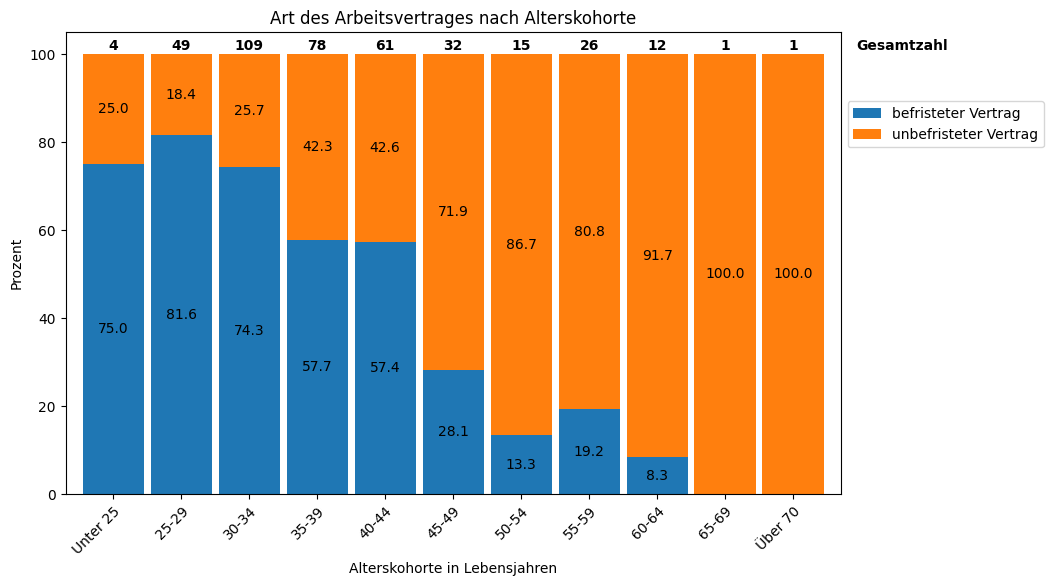

In [251]:
ax = df_age_level_vs_contracts[['ageLevel', 'FixedTermPerc', 'PermanentPerc', 'decodedLevel']].set_index('ageLevel').plot(kind='bar', 
                                                                                          stacked=True, 
                                                                                          figsize=(10, 6),                                                                                        
                                                                                          rot=45,
                                                                                          ylabel='Prozent',
                                                                                          xlabel='Alterskohorte in Lebensjahren',
                                                                                          width=0.9,
                                                                                          title='Art des Arbeitsvertrages nach Alterskohorte'
                                                                                          )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(df_age_level_vs_contracts['decodedLevel'], rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), labels=['befristeter Vertrag', 'unbefristeter Vertrag'])
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(df_age_level_vs_contracts['totals']):
    ax.text(df_age_level_vs_contracts['totals'].index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [252]:
fig = ax.get_figure()
fig.savefig('../reports/figures/M_01_Alter_vs_Arbeitsvertrag.png', bbox_inches='tight', dpi=300)

#### working contract vs being first academic

In [253]:
df_museum_1st_academics = df_museum[['CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?'] + ls_cols_contract]
df_museum_1st_academics

,CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?,M9. Sind Sie momentan befristet beschäftigt? _1,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle."
0,1.0,True,False
1,0.0,True,False
3,0.0,True,False
5,1.0,False,False
15,1.0,True,False
...,...,...,...
1000,1.0,True,False
1002,0.0,False,True
1004,0.0,False,True
1009,NaN,True,False


In [254]:
#create filter for those entries that answered True or False in both questions M9 (fixed term or permanent contract)
df_museum_1st_academics['M9_XOR'] = (df_museum_1st_academics['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] | df_museum_1st_academics['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.']) & ~(df_museum_1st_academics['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] & df_museum_1st_academics['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])
#filter out entries
df_museum_1st_academics_filtered = df_museum_1st_academics[df_museum_1st_academics['M9_XOR']==True]
df_museum_1st_academics_filtered.shape

/tmp/ipykernel_18666/3592959596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_museum_1st_academics['M9_XOR'] = (df_museum_1st_academics['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] | df_museum_1st_academics['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.']) & ~(df_museum_1st_academics['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] & df_museum_1st_academics['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])


(397, 4)

In [255]:
# Aggregate the data
df_ag_1st_acad = df_museum_1st_academics_filtered.groupby('CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?').agg(
    FixedTermSum=pd.NamedAgg(column=ls_cols_contract[0], aggfunc='sum'),
    PermanentSum=pd.NamedAgg(column=ls_cols_contract[1], aggfunc='sum')
).reset_index()

# Convert boolean sums to integer
df_ag_1st_acad['FixedTermSum'] = df_ag_1st_acad['FixedTermSum'].astype(int)
df_ag_1st_acad['PermanentSum'] = df_ag_1st_acad['PermanentSum'].astype(int)

# Calculate percentages
df_ag_1st_acad['totals'] = df_ag_1st_acad['FixedTermSum'] + df_ag_1st_acad['PermanentSum']
df_ag_1st_acad['FixedTermPerc'] = (df_ag_1st_acad['FixedTermSum'] / df_ag_1st_acad['totals'])*100
df_ag_1st_acad['PermanentPerc'] = (df_ag_1st_acad['PermanentSum'] / df_ag_1st_acad['totals'])*100

df_ag_1st_acad

,CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?,FixedTermSum,PermanentSum,totals,FixedTermPerc,PermanentPerc
0,0.0,130,90,220,59.090909,40.909091
1,1.0,86,76,162,53.086420,46.913580


Text(1.02, 0.985, 'Gesamtzahl')

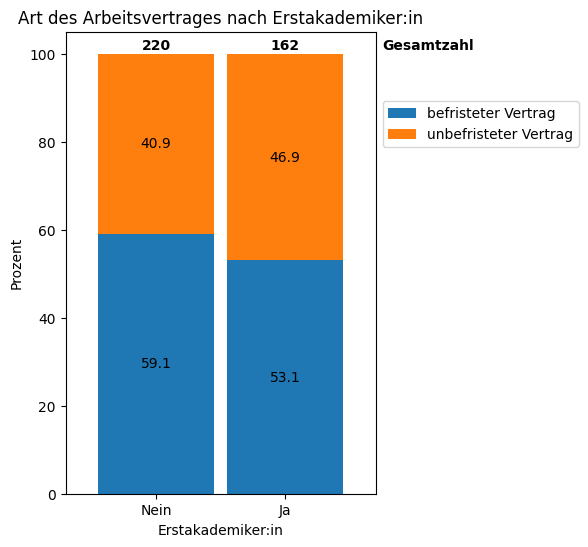

In [256]:
ax = df_ag_1st_acad[['CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?', 'FixedTermPerc', 'PermanentPerc']].set_index('CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?').plot(kind='bar', 
                                                                                          stacked=True, 
                                                                                          figsize=(4, 6),                                                                                        
                                                                                          #rot=45,
                                                                                          ylabel='Prozent',
                                                                                          xlabel='Erstakademiker:in',
                                                                                          width=0.9,
                                                                                          title='Art des Arbeitsvertrages nach Erstakademiker:in'
                                                                                          )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Nein', 'Ja'], rotation=0)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), labels=['befristeter Vertrag', 'unbefristeter Vertrag'])
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(df_ag_1st_acad['totals']):
    ax.text(df_ag_1st_acad['totals'].index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [257]:
fig = ax.get_figure()
fig.savefig('../reports/figures/M_02_Erstakademiker_vs_Arbeitsvertrag.png', bbox_inches='tight', dpi=300)

#### working contract vs first language German

In [258]:
df_museum_lang = df_museum[['CO4. Ist\xa0Deutsch Ihre Erstsprache?'] + ls_cols_contract]
df_museum_lang

,CO4. Ist Deutsch Ihre Erstsprache?,M9. Sind Sie momentan befristet beschäftigt? _1,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle."
0,1.0,True,False
1,0.0,True,False
3,1.0,True,False
5,1.0,False,False
15,1.0,True,False
...,...,...,...
1000,1.0,True,False
1002,1.0,False,True
1004,1.0,False,True
1009,0.0,True,False


In [259]:
#create filter for those entries that answered True or False in both questions M9 (fixed term or permanent contract)
df_museum_lang['M9_XOR'] = (df_museum_lang['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] | df_museum_lang['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.']) & ~(df_museum_lang['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] & df_museum_lang['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])
#filter out entries
df_museum_lang_filtered = df_museum_lang[df_museum_lang['M9_XOR']==True]
df_museum_lang_filtered.shape

/tmp/ipykernel_18666/2322248781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_museum_lang['M9_XOR'] = (df_museum_lang['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] | df_museum_lang['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.']) & ~(df_museum_lang['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] & df_museum_lang['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])


(397, 4)

In [260]:
# Aggregate the data
df_ag_lang = df_museum_lang_filtered.groupby('CO4. Ist\xa0Deutsch Ihre Erstsprache?').agg(
    FixedTermSum=pd.NamedAgg(column=ls_cols_contract[0], aggfunc='sum'),
    PermanentSum=pd.NamedAgg(column=ls_cols_contract[1], aggfunc='sum')
).reset_index()

# Convert boolean sums to integer
df_ag_lang['FixedTermSum'] = df_ag_lang['FixedTermSum'].astype(int)
df_ag_lang['PermanentSum'] = df_ag_lang['PermanentSum'].astype(int)

# Calculate percentages
df_ag_lang['totals'] = df_ag_lang['FixedTermSum'] + df_ag_lang['PermanentSum']
df_ag_lang['FixedTermPerc'] = (df_ag_lang['FixedTermSum'] / df_ag_lang['totals'])*100
df_ag_lang['PermanentPerc'] = (df_ag_lang['PermanentSum'] / df_ag_lang['totals'])*100

df_ag_lang

,CO4. Ist Deutsch Ihre Erstsprache?,FixedTermSum,PermanentSum,totals,FixedTermPerc,PermanentPerc
0,0.0,12,5,17,70.588235,29.411765
1,1.0,212,166,378,56.084656,43.915344


Text(1.02, 0.985, 'Gesamtzahl')

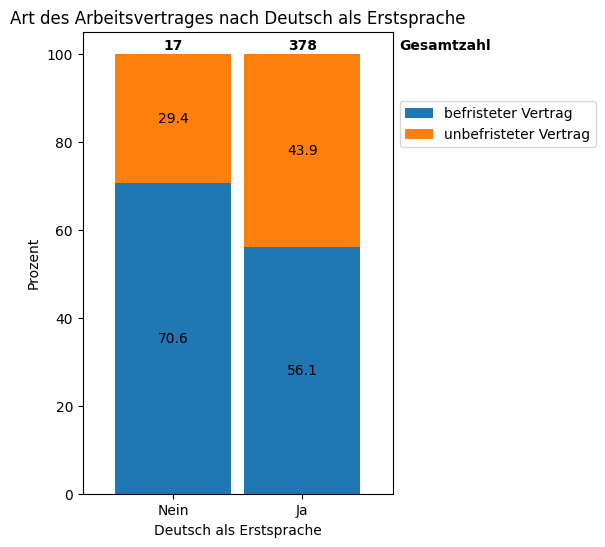

In [261]:
ax = df_ag_lang[['CO4. Ist\xa0Deutsch Ihre Erstsprache?', 'FixedTermPerc', 'PermanentPerc']].set_index('CO4. Ist\xa0Deutsch Ihre Erstsprache?').plot(kind='bar', 
                                                                                          stacked=True, 
                                                                                          figsize=(4, 6),                                                                                        
                                                                                          #rot=45,
                                                                                          ylabel='Prozent',
                                                                                          xlabel='Deutsch als Erstsprache',
                                                                                          width=0.9,
                                                                                          title='Art des Arbeitsvertrages nach Deutsch als Erstsprache'
                                                                                          )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(['Nein', 'Ja'], rotation=0)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), labels=['befristeter Vertrag', 'unbefristeter Vertrag'])
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(df_ag_lang['totals']):
    ax.text(df_age_level_vs_contracts['totals'].index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [262]:
fig = ax.get_figure()
fig.savefig('../reports/figures/M_03_Erstsprache_vs_Arbeitsvertrag.png', bbox_inches='tight', dpi=300)

#### working contract vs gender

In [263]:
ls_cols_gender = [col for col in df_whole if col.startswith('CO6.')]
df_museum_gender = df_museum[ls_cols_gender + ls_cols_contract]
df_museum_gender

,CO6. Welchem Geschlecht ordnen Sie sich zu?_Divers,CO6. Welchem Geschlecht ordnen Sie sich zu?_Männlich,CO6. Welchem Geschlecht ordnen Sie sich zu?_Weiblich,M9. Sind Sie momentan befristet beschäftigt? _1,"M9. Sind Sie momentan befristet beschäftigt? _Nein, ich habe eine entfristete Stelle."
0,False,True,False,True,False
1,False,False,True,True,False
3,False,False,True,True,False
5,False,True,False,False,False
15,False,False,True,True,False
...,...,...,...,...,...
1000,False,False,True,True,False
1002,False,False,True,False,True
1004,False,False,True,False,True
1009,False,False,True,True,False


In [264]:
#create filter for those entries that answered True or False in both questions M9 (fixed term or permanent contract)
df_museum_gender['M9_XOR'] = (df_museum_gender['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] | df_museum_gender['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.']) & ~(df_museum_gender['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] & df_museum_gender['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])
#filter out entries
df_museum_gender_filtered = df_museum_gender[df_museum_gender['M9_XOR']==True]
df_museum_gender_filtered.shape

/tmp/ipykernel_18666/4190739168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_museum_gender['M9_XOR'] = (df_museum_gender['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] | df_museum_gender['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.']) & ~(df_museum_gender['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'] & df_museum_gender['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])


(397, 6)

In [265]:
# List to hold the data for the new DataFrame
data_for_new_df = []

# age levels
gender_levels = ls_cols_gender

# Calculate sums for each age level
for level in gender_levels:
    fixed_term_sum = df_museum_gender_filtered[(df_museum_gender_filtered[level]) & (df_museum_gender_filtered['M9. Sind Sie momentan befristet beschäftigt?\xa0_1'])].shape[0]
    permanent_sum = df_museum_gender_filtered[(df_museum_gender_filtered[level]) & (df_museum_gender_filtered['M9. Sind Sie momentan befristet beschäftigt?\xa0_Nein, ich habe eine entfristete Stelle.'])].shape[0]
    
    data_for_new_df.append({
        'Gender': level,
        'FixedTermSum': fixed_term_sum,
        'PermanentSum': permanent_sum
    })

# Convert the list of dictionaries to a DataFrame
df_museum_gender_contract_filtered = pd.DataFrame(data_for_new_df)
df_museum_gender_contract_filtered['Gender'] = ['divers', 'männlich', 'weiblich']

df_museum_gender_contract = df_museum_gender_contract_filtered.sort_values(by='Gender').reset_index().drop('index', axis=1)
df_museum_gender_contract

,Gender,FixedTermSum,PermanentSum
0,divers,1,0
1,männlich,28,43
2,weiblich,194,128


In [266]:
# Calculate percentages
df_museum_gender_contract['totals'] = df_museum_gender_contract['FixedTermSum'] + df_museum_gender_contract['PermanentSum']
df_museum_gender_contract['FixedTermPerc'] = (df_museum_gender_contract['FixedTermSum'] / df_museum_gender_contract['totals'])*100
df_museum_gender_contract['PermanentPerc'] = (df_museum_gender_contract['PermanentSum'] / df_museum_gender_contract['totals'])*100
df_museum_gender_contract

,Gender,FixedTermSum,PermanentSum,totals,FixedTermPerc,PermanentPerc
0,divers,1,0,1,100.000000,0.000000
1,männlich,28,43,71,39.436620,60.563380
2,weiblich,194,128,322,60.248447,39.751553


Text(1.02, 0.985, 'Gesamtzahl')

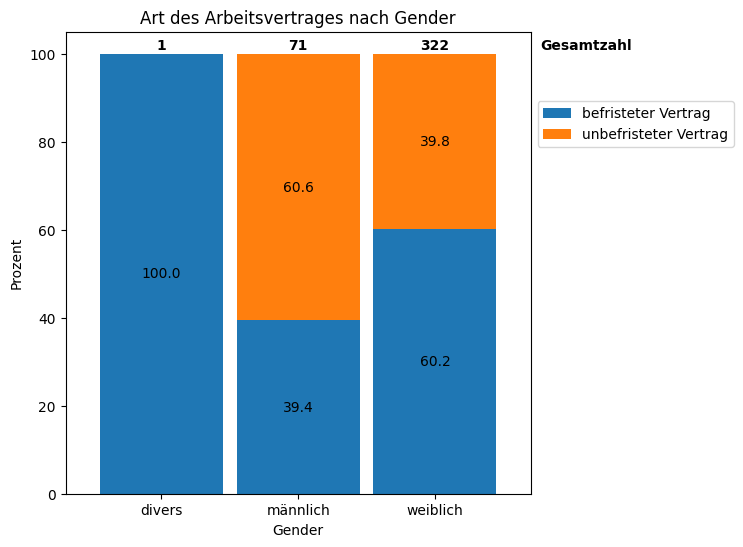

In [267]:
ax = df_museum_gender_contract[['Gender', 'FixedTermPerc', 'PermanentPerc']].set_index('Gender').plot(kind='bar', 
                                                                                          stacked=True, 
                                                                                          figsize=(6, 6),                                                                                        
                                                                                          #rot=45,
                                                                                          ylabel='Prozent',
                                                                                          xlabel='Gender',
                                                                                          width=0.9,
                                                                                          title='Art des Arbeitsvertrages nach Gender'
                                                                                          )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(df_museum_gender_contract['Gender'], rotation=0)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), labels=['befristeter Vertrag', 'unbefristeter Vertrag'])
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(df_museum_gender_contract['totals']):
    ax.text(df_museum_gender_contract['totals'].index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [268]:
fig = ax.get_figure()
fig.savefig('../reports/figures/M_04_Gender_vs_Arbeitsvertrag.png', bbox_inches='tight', dpi=300)

## bullying

In [269]:
#extract columns with career and bullying
ls_cols_career = [col for col in df_whole if col.startswith('AP14')]
ls_cols_bullying = [col for col in df_whole if col.startswith('CO7r')]

#extract career levels
career = [entry.split('Fragen:\xa0_')[1] for entry in ls_cols_career]
print(career)
print(ls_cols_career)

#extract bullying levels
# Regular expression to find a string inside square brackets at the end of column
pattern = re.compile(r'\[([^\]]*)\]$')
bullying_levels = [pattern.search(col).group(1) if pattern.search(col) else None for col in ls_cols_bullying]
print(bullying_levels)

['Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit', 'Freiberufler:in', 'Freie Wirtschaft', 'Museums- oder Ausstellungswesen und Denkmalpflege', 'Stipendiat:in', 'Universität, Hochschule oder außeruniversitäre Forschungseinrichtung']
['AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.\xa0  Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen:\xa0_Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit', 'AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.\xa0  Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für S

In [270]:
df_career_bully = df_whole[ls_cols_career + ['CO7. Werden oder wurden Sie im beruflichen Umfeld diskriminiert, abgewertet, gemobbt oder ohne sachliche Rechtfertigung benachteiligt?\xa0\xa0']]
df_career_bully

,"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung","CO7. Werden oder wurden Sie im beruflichen Umfeld diskriminiert, abgewertet, gemobbt oder ohne sachliche Rechtfertigung benachteiligt?"
0,False,False,False,True,False,False,0.0
1,False,False,False,True,False,False,0.0
2,False,False,False,False,True,False,1.0
3,False,False,False,True,False,False,1.0
4,False,False,False,False,False,True,0.0
...,...,...,...,...,...,...,...
1010,False,True,False,False,False,False,0.0
1011,False,False,False,False,False,True,1.0
1012,False,False,False,True,False,False,NaN
1013,True,False,False,False,False,False,0.0


In [271]:
# Melt the DataFrame
df_career_bully_melt = df_career_bully.melt(id_vars=['CO7. Werden oder wurden Sie im beruflichen Umfeld diskriminiert, abgewertet, gemobbt oder ohne sachliche Rechtfertigung benachteiligt?\xa0\xa0'], var_name='CareerPath', value_name='IsInPath')

# Filter out rows where IsInPath is False
df_career_bully_filter = df_career_bully_melt[df_career_bully_melt['IsInPath'] == True]
df_career_bully_filter

# Group by CareerPath and BullyingExperienced and count occurrences
df_career_bully_agg = df_career_bully_filter.groupby(['CareerPath', 'CO7. Werden oder wurden Sie im beruflichen Umfeld diskriminiert, abgewertet, gemobbt oder ohne sachliche Rechtfertigung benachteiligt?\xa0\xa0']).size().reset_index(name='Count')
df_career_bully_agg

# Pivot to wide format
df_career_bully_pivot = df_career_bully_agg.pivot(index='CareerPath', columns='CO7. Werden oder wurden Sie im beruflichen Umfeld diskriminiert, abgewertet, gemobbt oder ohne sachliche Rechtfertigung benachteiligt?\xa0\xa0', values='Count').fillna(0)
df_career_bully_pivot

# Rename columns for clarity
df_career_bully_pivot.columns = ['BullyingNotExperienced', 'BullyingExperienced']

# Reset index to turn the index into a column
df_career_bully_pivot.reset_index(inplace=True)
df_career_bully_pivot['CareerPath'] = career

# calculate percentage values
df_career_bully_pivot['totals'] = df_career_bully_pivot['BullyingExperienced'] + df_career_bully_pivot['BullyingNotExperienced']
df_career_bully_pivot['BullyingNotExperienced_Perc'] = (df_career_bully_pivot['BullyingNotExperienced'] / df_career_bully_pivot['totals'])*100
df_career_bully_pivot['BullyingExperienced_Perc'] = (df_career_bully_pivot['BullyingExperienced'] / df_career_bully_pivot['totals'])*100
df_career_bully_pivot


,CareerPath,BullyingNotExperienced,BullyingExperienced,totals,BullyingNotExperienced_Perc,BullyingExperienced_Perc
0,Arbeitssuchend bzw. ohne bezahlte kunstwissens...,33,37,70,47.142857,52.857143
1,Freiberufler:in,58,48,106,54.716981,45.283019
2,Freie Wirtschaft,30,14,44,68.181818,31.818182
3,Museums- oder Ausstellungswesen und Denkmalpflege,252,121,373,67.560322,32.439678
4,Stipendiat:in,25,17,42,59.523810,40.476190
5,"Universität, Hochschule oder außeruniversitäre...",172,97,269,63.940520,36.059480


Text(1.02, 0.985, 'Gesamtzahl')

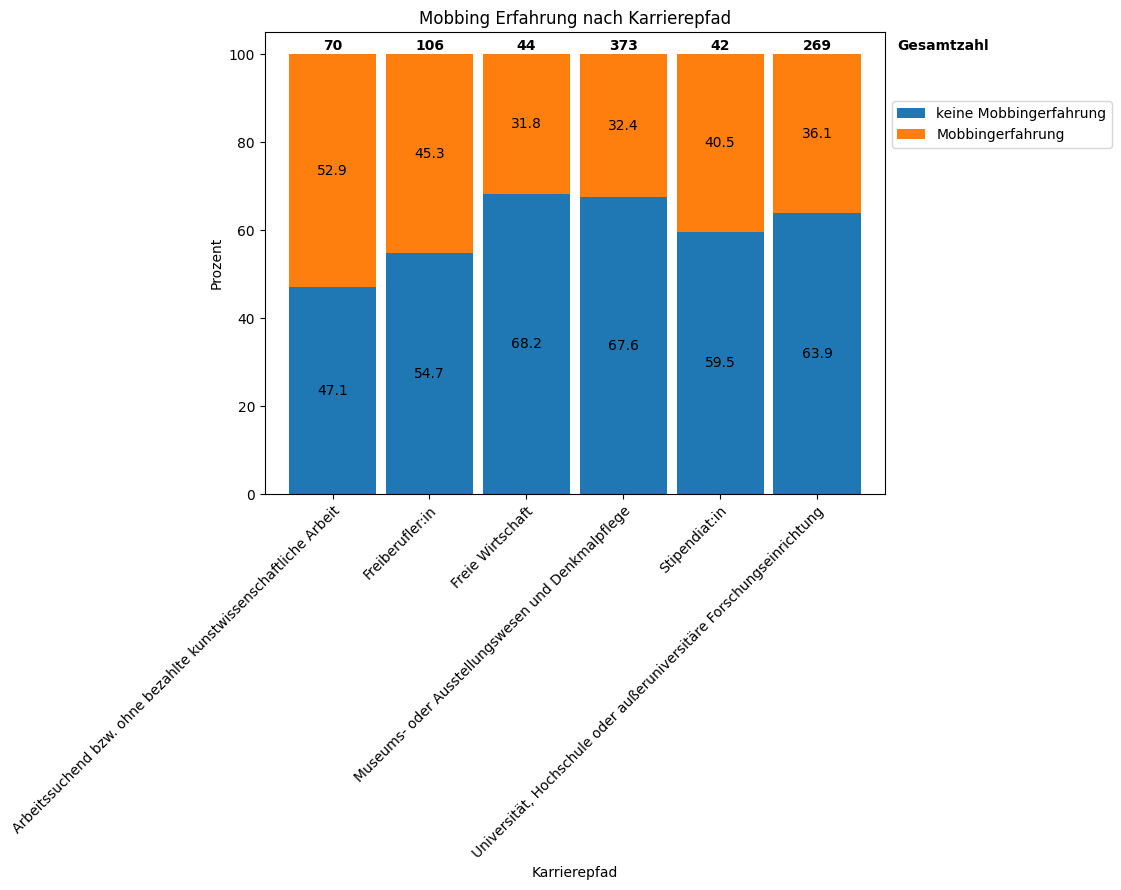

In [272]:
ax = df_career_bully_pivot[['CareerPath', 'BullyingNotExperienced_Perc', 'BullyingExperienced_Perc']].set_index('CareerPath').plot(kind='bar', 
                                                                                          stacked=True, 
                                                                                          figsize=(8, 6),                                                                                        
                                                                                          #rot=45,
                                                                                          ylabel='Prozent',
                                                                                          xlabel='Karrierepfad',
                                                                                          width=0.9,
                                                                                          title='Mobbing Erfahrung nach Karrierepfad'
                                                                                          )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(df_career_bully_pivot['CareerPath'], rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), labels=['keine Mobbingerfahrung', 'Mobbingerfahrung'])
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(df_career_bully_pivot['totals']):
    ax.text(df_career_bully_pivot['totals'].index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [273]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AP_00_Pfad_vs_Mobbing.png', bbox_inches='tight', dpi=300)

In [274]:
ls_cols_bullying

['CO7r[SQ001]. Aus welchen Gründen? [Abschluss oder akademischer Grad]',
 'CO7r[SQ002]. Aus welchen Gründen? [Alter ]',
 'CO7r[SQ003]. Aus welchen Gründen? [Beeinträchtigung bzw. chronische Krankheit ]',
 'CO7r[SQ004]. Aus welchen Gründen? [Care-Verpflichtungen: Kinder]',
 'CO7r[SQ005]. Aus welchen Gründen? [Care-Verpflichtungen: pflegebedürftige Angehörige]',
 'CO7r[SQ006]. Aus welchen Gründen? [Erstsprache ]',
 'CO7r[SQ007]. Aus welchen Gründen? [Geschlecht bzw. Geschlechtsidentität]',
 'CO7r[SQ008]. Aus welchen Gründen? [Klasse (z.B. Erstakademiker:in)]',
 'CO7r[SQ009]. Aus welchen Gründen? [Konkurrenzkämpfe]',
 'CO7r[SQ010]. Aus welchen Gründen? [Rassifizierende Zuschreibung]',
 'CO7r[SQ011]. Aus welchen Gründen? [Religion bzw. Weltanschauung (inklusive Zuschreibungen)]',
 'CO7r[SQ012]. Aus welchen Gründen? [Sexuelle Identität bzw. Orientierung (inklusive Zuschreibungen)]',
 'CO7r[SQ013]. Aus welchen Gründen? [Staatsangehörigkeit]']

#### bullying types vs career paths

In [275]:
#Analysis of only those entries that experienced bullying
df_bullying = df_whole[df_whole['CO7. Werden oder wurden Sie im beruflichen Umfeld diskriminiert, abgewertet, gemobbt oder ohne sachliche Rechtfertigung benachteiligt?\xa0\xa0']==1]

In [276]:
len(df_bullying['CO7. Werden oder wurden Sie im beruflichen Umfeld diskriminiert, abgewertet, gemobbt oder ohne sachliche Rechtfertigung benachteiligt?\xa0\xa0'])

334

In [277]:
df_bullying_types = df_bullying[ls_cols_career + ls_cols_bullying]
df_bullying_types

,"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",CO7r[SQ001]. Aus welchen Gründen? [Abschluss oder akademischer Grad],CO7r[SQ002]. Aus welchen Gründen? [Alter ],CO7r[SQ003]. Aus welchen Gründen? [Beeinträchtigung bzw. chronische Krankheit ],CO7r[SQ004]. Aus welchen Gründen? [Care-Verpflichtungen: Kinder],CO7r[SQ005]. Aus welchen Gründen? [Care-Verpflichtungen: pflegebedürftige Angehörige],CO7r[SQ006]. Aus welchen Gründen? [Erstsprache ],CO7r[SQ007]. Aus welchen Gründen? [Geschlecht bzw. Geschlechtsidentität],CO7r[SQ008]. Aus welchen Gründen? [Klasse (z.B. Erstakademiker:in)],CO7r[SQ009]. Aus welchen Gründen? [Konkurrenzkämpfe],CO7r[SQ010]. Aus welchen Gründen? [Rassifizierende Zuschreibung],CO7r[SQ011]. Aus welchen Gründen? [Religion bzw. Weltanschauung (inklusive Zuschreibungen)],CO7r[SQ012]. Aus welchen Gründen? [Sexuelle Identität bzw. Orientierung (inklusive Zuschreibungen)],CO7r[SQ013]. Aus welchen Gründen? [Staatsangehörigkeit]
2,False,False,False,False,True,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,False,False,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,False,False,False,False,False,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11,False,False,False,False,False,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14,False,True,False,False,False,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,False,False,False,True,False,False,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1004,False,False,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1008,False,False,False,False,False,True,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0

In [278]:
# initialize empty DataFrame
aggregated_df = pd.DataFrame(index=ls_cols_career, columns=ls_cols_bullying).fillna(0)

for career_path in ls_cols_career:
    for bullying_type in ls_cols_bullying:
        # Sum the bullying counts for the current career path
        aggregated_df.loc[career_path, bullying_type] = df_whole[df_whole[career_path] == True][bullying_type].sum()
        
# rename indices and column names
aggregated_df.columns = bullying_levels

#aggregated_df.index = career
aggregated_df['totals'] = aggregated_df.sum(axis=1)

In [279]:
ls_perc_columns = []
for bullying_type in aggregated_df.loc[:, aggregated_df.columns != 'totals'].columns:
    percentage_column_name = f'{bullying_type}Percentage'
    ls_perc_columns.append(percentage_column_name)
    aggregated_df[percentage_column_name] = (aggregated_df[bullying_type] / aggregated_df['totals']) * 100
    
#aggregated_df = aggregated_df.reset_index()

In [280]:
aggregated_df[ls_perc_columns].sum(axis=1)

AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.   Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit         100.0
AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.   Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in                                                         100.0
AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern 

In [281]:
aggregated_df['totals']

AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.   Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit          88
AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.   Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in                                                         115
AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von 

In [282]:
aggregated_df = aggregated_df.reset_index()

In [283]:
aggregated_df['index'] = career
aggregated_df = aggregated_df.rename(columns={'index':'Career'})

Text(1.02, 0.5, 'Mehrfachnennung waren möglich')

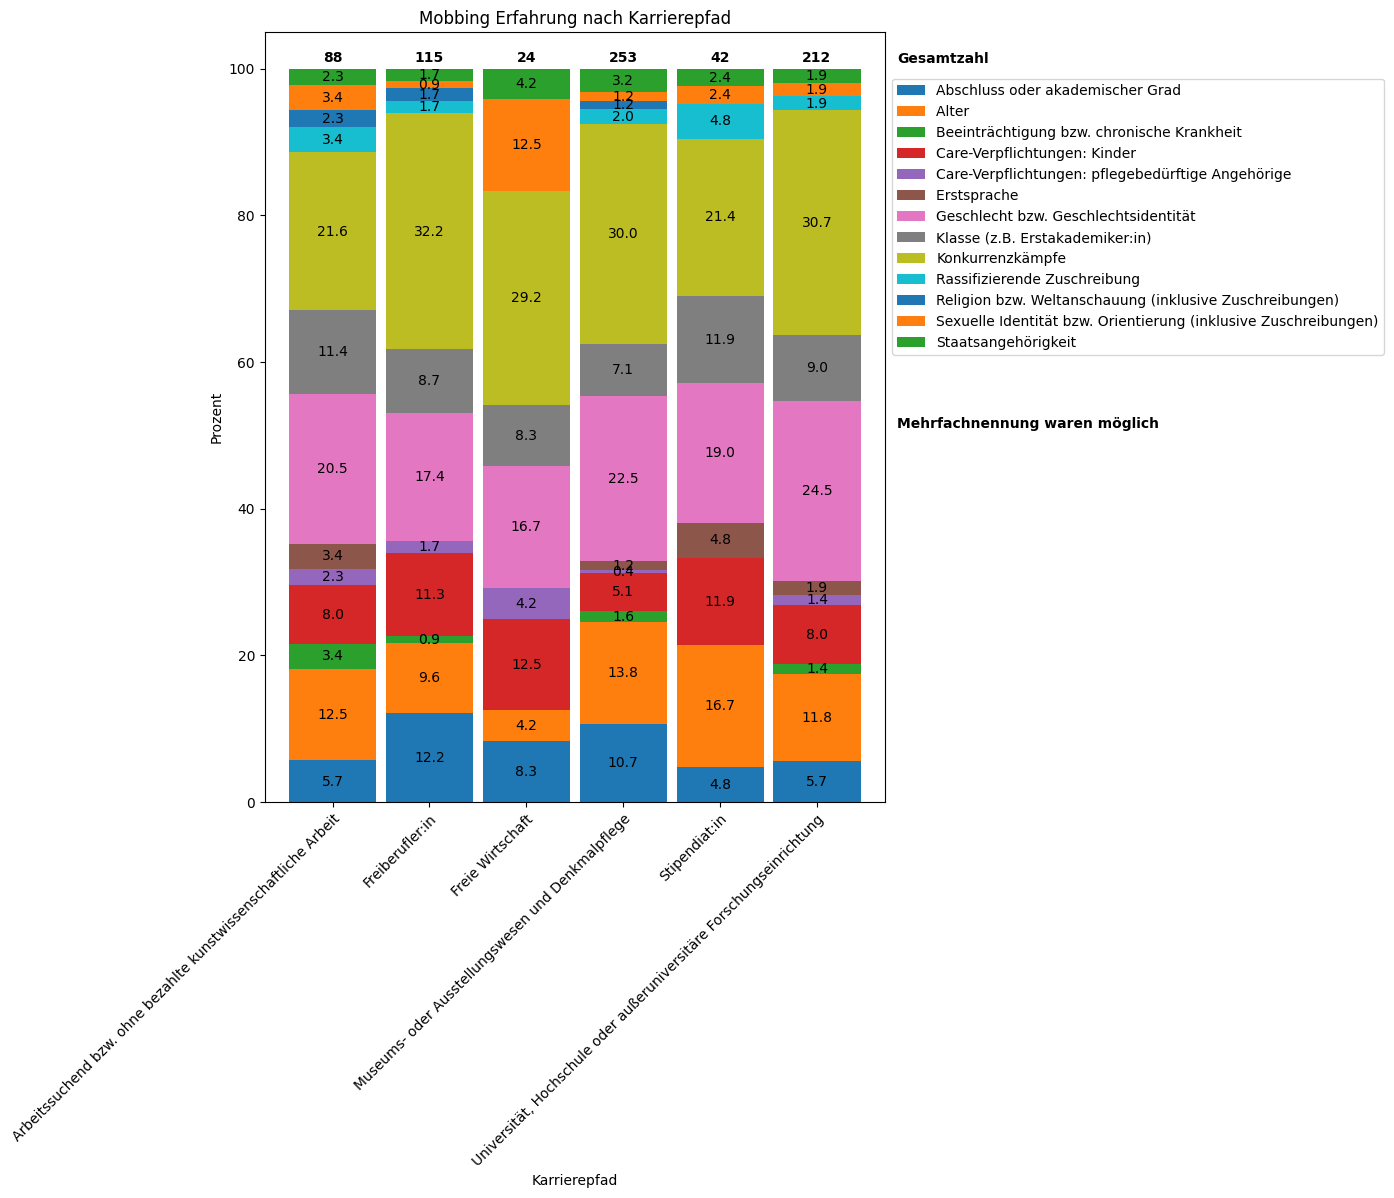

In [284]:
ax = aggregated_df[ls_perc_columns].plot(kind='bar', 
                        stacked=True, 
                        figsize=(8, 10),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        xlabel='Karrierepfad',
                        width=0.9,
                        title='Mobbing Erfahrung nach Karrierepfad'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(aggregated_df['Career'], rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.76), labels=bullying_levels)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(aggregated_df['totals']):
    ax.text(aggregated_df['totals'].index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')
ax.text(1.02, 0.5, 'Mehrfachnennung waren möglich', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')
    


In [285]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AP_01_Pfad_vs_Mobbingarten.png', bbox_inches='tight', dpi=300)

Hypothesis: Stipendholders report more often mobbing based on their first language (CO4) and class (CO1) because there are more non-native speaker and first time academics among them. 

In [286]:
df_career_lang = df_whole[ls_cols_career + ['CO4. Ist\xa0Deutsch Ihre Erstsprache?']]
df_career_lang

,"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",CO4. Ist Deutsch Ihre Erstsprache?
0,False,False,False,True,False,False,1.0
1,False,False,False,True,False,False,0.0
2,False,False,False,False,True,False,1.0
3,False,False,False,True,False,False,1.0
4,False,False,False,False,False,True,1.0
...,...,...,...,...,...,...,...
1010,False,True,False,False,False,False,1.0
1011,False,False,False,False,False,True,1.0
1012,False,False,False,True,False,False,1.0
1013,True,False,False,False,False,False,1.0


In [287]:
# Melt the DataFrame
df_career_lang_melt = df_career_lang.melt(id_vars=['CO4. Ist\xa0Deutsch Ihre Erstsprache?'], var_name='CareerPath', value_name='IsInPath')

# Filter out rows where IsInPath is False
df_career_lang_filter = df_career_lang_melt[df_career_lang_melt['IsInPath'] == True]

# Group by CareerPath and native language and count occurrences
df_career_lang_agg = df_career_lang_filter.groupby(['CareerPath', 'CO4. Ist\xa0Deutsch Ihre Erstsprache?']).size().reset_index(name='Count')

# Pivot to wide format
df_career_lang_pivot = df_career_lang_agg.pivot(index='CareerPath', columns='CO4. Ist\xa0Deutsch Ihre Erstsprache?', values='Count').fillna(0)

# Rename columns for clarity
df_career_lang_pivot.columns = ['NonNative', 'Native']

# Reset index to turn the index into a column
df_career_lang_pivot.reset_index(inplace=True)
df_career_lang_pivot['CareerPath'] = career

# calculate percentage values
df_career_lang_pivot['totals'] = df_career_lang_pivot['NonNative'] + df_career_lang_pivot['Native']
df_career_lang_pivot['NonNative_Perc'] = (df_career_lang_pivot['NonNative'] / df_career_lang_pivot['totals'])*100
df_career_lang_pivot['Native_Perc'] = (df_career_lang_pivot['Native'] / df_career_lang_pivot['totals'])*100
df_career_lang_pivot


,CareerPath,NonNative,Native,totals,NonNative_Perc,Native_Perc
0,Arbeitssuchend bzw. ohne bezahlte kunstwissens...,6,68,74,8.108108,91.891892
1,Freiberufler:in,6,107,113,5.309735,94.690265
2,Freie Wirtschaft,2,44,46,4.347826,95.652174
3,Museums- oder Ausstellungswesen und Denkmalpflege,17,383,400,4.250000,95.750000
4,Stipendiat:in,4,40,44,9.090909,90.909091
5,"Universität, Hochschule oder außeruniversitäre...",24,265,289,8.304498,91.695502


Text(1.02, 0.985, 'Gesamtzahl')

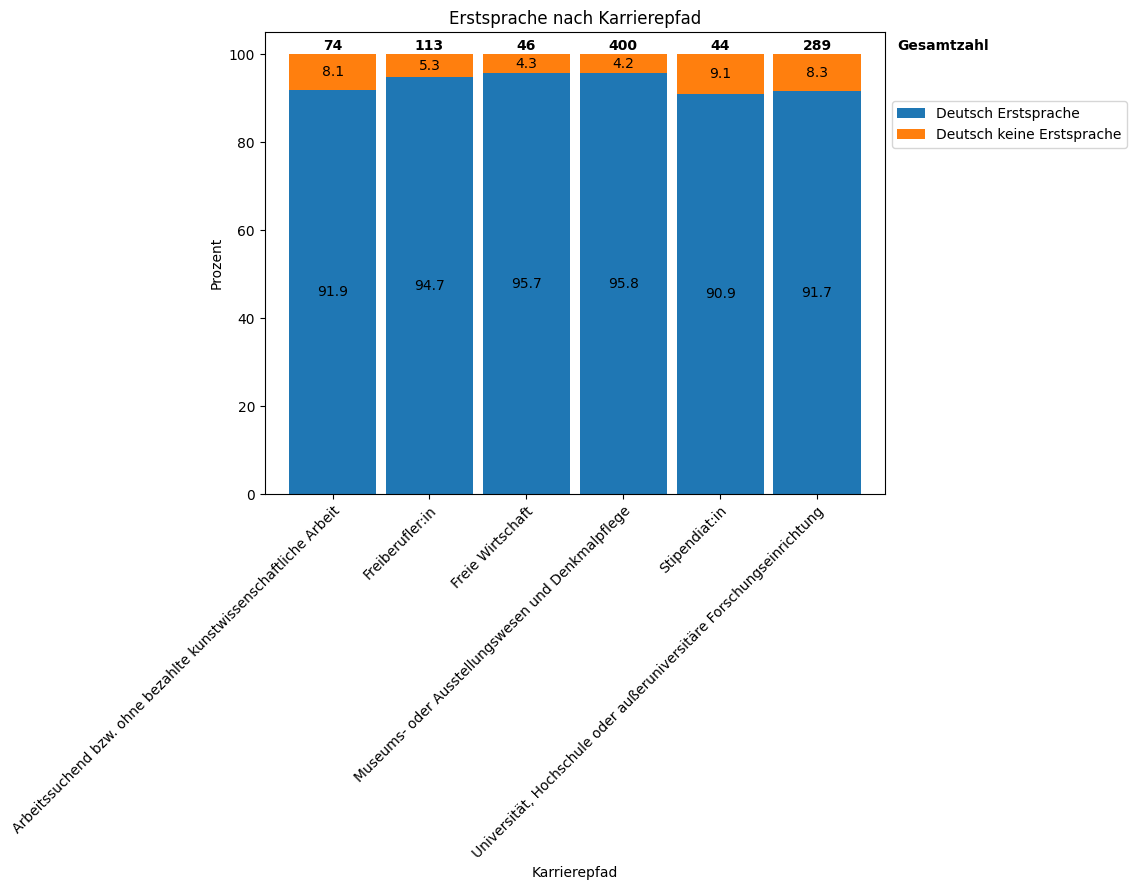

In [288]:
ax = df_career_lang_pivot[['CareerPath', 'Native_Perc', 'NonNative_Perc']].set_index('CareerPath').plot(kind='bar', 
                                                                                          stacked=True, 
                                                                                          figsize=(8, 6),                                                                                        
                                                                                          #rot=45,
                                                                                          ylabel='Prozent',
                                                                                          xlabel='Karrierepfad',
                                                                                          width=0.9,
                                                                                          title='Erstsprache nach Karrierepfad'
                                                                                          )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(df_career_lang_pivot['CareerPath'], rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), labels=['Deutsch Erstsprache', 'Deutsch keine Erstsprache'])
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(df_career_lang_pivot['totals']):
    ax.text(df_career_lang_pivot['totals'].index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [289]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AP_02_Pfad_vs_Erstsprache.png', bbox_inches='tight', dpi=300)

Yes stipend holders have the highest percentage of non-native german speaking individuals. However it's not significantly more than the population of individuals working in universities and non-university academic institutions. This does not explain why stipend holders face more bullying based on their native language.

In [290]:
df_career_class = df_whole[ls_cols_career + ['CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?']]
df_career_class

,"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?
0,False,False,False,True,False,False,1.0
1,False,False,False,True,False,False,0.0
2,False,False,False,False,True,False,1.0
3,False,False,False,True,False,False,0.0
4,False,False,False,False,False,True,1.0
...,...,...,...,...,...,...,...
1010,False,True,False,False,False,False,1.0
1011,False,False,False,False,False,True,0.0
1012,False,False,False,True,False,False,0.0
1013,True,False,False,False,False,False,1.0


In [291]:
# Melt the DataFrame
df_career_class_melt = df_career_class.melt(id_vars=['CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?'], var_name='CareerPath', value_name='IsInPath')

# Filter out rows where IsInPath is False
df_career_class_filter = df_career_class_melt[df_career_class_melt['IsInPath'] == True]

# Group by CareerPath and native classuage and count occurrences
df_career_class_agg = df_career_class_filter.groupby(['CareerPath', 'CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?']).size().reset_index(name='Count')

# Pivot to wide format
df_career_class_pivot = df_career_class_agg.pivot(index='CareerPath', columns='CO1. Sind Sie sogenannte:r Erstakademiker:in in Ihrer Familie?', values='Count').fillna(0)

# Rename columns for clarity
df_career_class_pivot.columns = ['NonFirst', 'First']

# Reset index to turn the index into a column
df_career_class_pivot.reset_index(inplace=True)
df_career_class_pivot['CareerPath'] = career

# calculate percentage values
df_career_class_pivot['totals'] = df_career_class_pivot['NonFirst'] + df_career_class_pivot['First']
df_career_class_pivot['NonFirst_Perc'] = (df_career_class_pivot['NonFirst'] / df_career_class_pivot['totals'])*100
df_career_class_pivot['First_Perc'] = (df_career_class_pivot['First'] / df_career_class_pivot['totals'])*100
df_career_class_pivot


,CareerPath,NonFirst,First,totals,NonFirst_Perc,First_Perc
0,Arbeitssuchend bzw. ohne bezahlte kunstwissens...,40,34,74,54.054054,45.945946
1,Freiberufler:in,60,51,111,54.054054,45.945946
2,Freie Wirtschaft,24,21,45,53.333333,46.666667
3,Museums- oder Ausstellungswesen und Denkmalpflege,221,166,387,57.105943,42.894057
4,Stipendiat:in,20,25,45,44.444444,55.555556
5,"Universität, Hochschule oder außeruniversitäre...",160,117,277,57.761733,42.238267


Text(1.02, 0.985, 'Gesamtzahl')

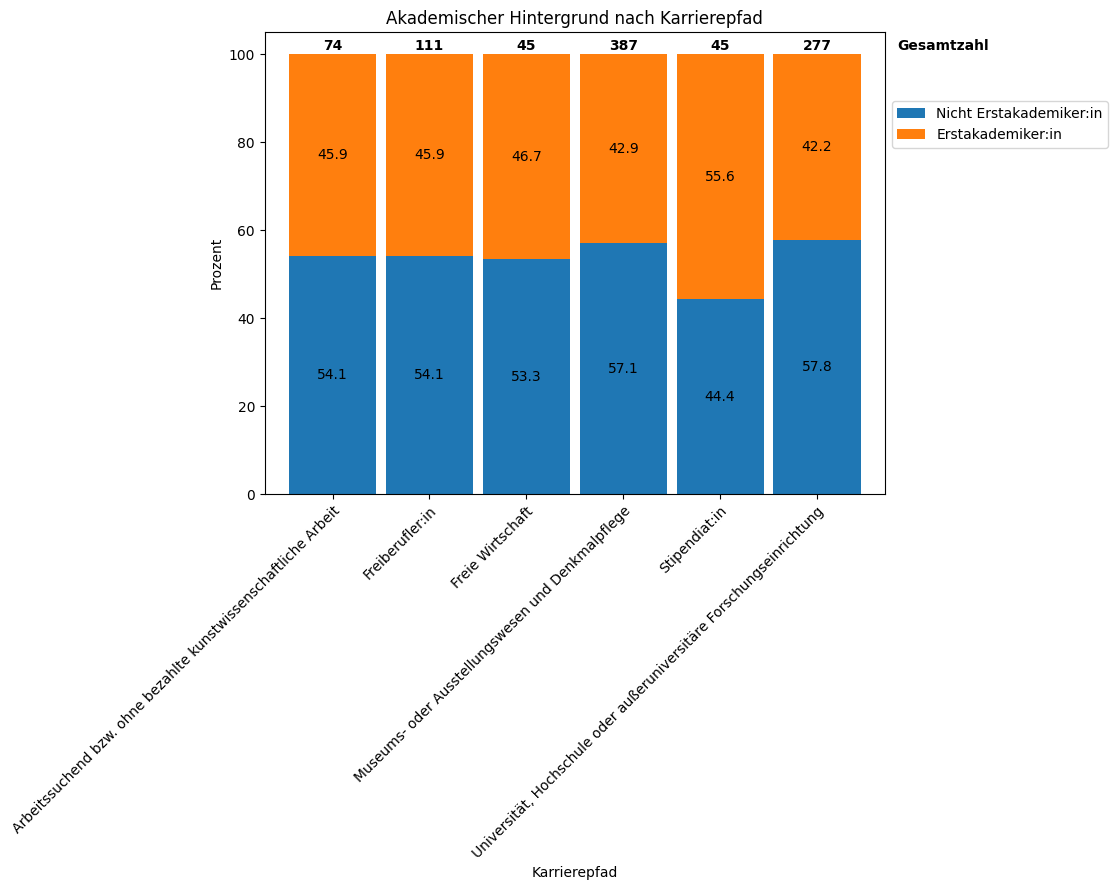

In [292]:
ax = df_career_class_pivot[['CareerPath', 'NonFirst_Perc', 'First_Perc']].set_index('CareerPath').plot(kind='bar', 
                                                                                          stacked=True, 
                                                                                          figsize=(8, 6),                                                                                        
                                                                                          #rot=45,
                                                                                          ylabel='Prozent',
                                                                                          xlabel='Karrierepfad',
                                                                                          width=0.9,
                                                                                          title='Akademischer Hintergrund nach Karrierepfad'
                                                                                          )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(df_career_class_pivot['CareerPath'], rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), labels=['Nicht Erstakademiker:in', 'Erstakademiker:in'])
    
#add total values of entries above bar
y_offset = 4
for i, total in enumerate(df_career_class_pivot['totals']):
    ax.text(df_career_class_pivot['totals'].index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [293]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AP_03_Pfad_vs_Erstakademie.png', bbox_inches='tight', dpi=300)

There are indeed ~ 10% more stipend holders that report to be first in their families to have an academic degree. This could explain why there are more reported cases of classism within stipend holders.

#### Career vs. Age Group

In [294]:
df_career_age = df_whole[ls_cols_age_level + ls_cols_career]
df_career_age

,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,AP1. Wie alt sind Sie?_7.0,AP1. Wie alt sind Sie?_8.0,AP1. Wie alt sind Sie?_9.0,AP1. Wie alt sind Sie?_10.0,"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in","AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung"
0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False
1011,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1012,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False
1013,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [295]:
# initialize empty DataFrame
aggregated_df = pd.DataFrame(index=ls_cols_career, columns=ls_cols_age_level).fillna(0)

for career_path in ls_cols_career:
    for age_level in ls_cols_age_level:
        # Sum the bullying counts for the current career path
        aggregated_df.loc[career_path, age_level] = df_whole[df_whole[career_path] == True][age_level].sum()
        
# rename indices and column names
aggregated_df.columns = ls_cols_age_level

#aggregated_df.index = career
aggregated_df['totals'] = aggregated_df.sum(axis=1)
aggregated_df

,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,AP1. Wie alt sind Sie?_7.0,AP1. Wie alt sind Sie?_8.0,AP1. Wie alt sind Sie?_9.0,AP1. Wie alt sind Sie?_10.0,totals
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit",0,7,23,22,7,3,8,2,1,1,0,74
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in",1,7,19,11,16,16,18,13,8,2,1,112
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft",1,3,13,7,12,3,4,3,1,1,0,48
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege",4,49,109,78,62,33,15,26,12,2,3,393
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",1,8,26,7,3,0,0,0,0,0,0,45
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",2,31,70,66,45,26,17,14,7,2,1,281


In [296]:
ls_perc_columns = []
for age_level in aggregated_df.loc[:, aggregated_df.columns != 'totals'].columns:
    percentage_column_name = f'{age_level}Percentage'
    ls_perc_columns.append(percentage_column_name)
    aggregated_df[percentage_column_name] = (aggregated_df[age_level] / aggregated_df['totals']) * 100
    
aggregated_df

,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,AP1. Wie alt sind Sie?_7.0,AP1. Wie alt sind Sie?_8.0,AP1. Wie alt sind Sie?_9.0,...,AP1. Wie alt sind Sie?_1.0Percentage,AP1. Wie alt sind Sie?_2.0Percentage,AP1. Wie alt sind Sie?_3.0Percentage,AP1. Wie alt sind Sie?_4.0Percentage,AP1. Wie alt sind Sie?_5.0Percentage,AP1. Wie alt sind Sie?_6.0Percentage,AP1. Wie alt sind Sie?_7.0Percentage,AP1. Wie alt sind Sie?_8.0Percentage,AP1. Wie alt sind Sie?_9.0Percentage,AP1. Wie alt sind Sie?_10.0Percentage
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit",0,7,23,22,7,3,8,2,1,1,...,9.459459,31.081081,29.729730,9.459459,4.054054,10.810811,2.702703,1.351351,1.351351,0.000000
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in",1,7,19,11,16,16,18,13,8,2,...,6.250000,16.964286,9.821429,14.285714,14.285714,16.071429,11.607143,7.142857,1.785714,0.892857
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freie Wirtschaft",1,3,13,7,12,3,4,3,1,1,...,6.250000,27.083333,14.583333,25.000000,6.250000,8.333333,6.250000,2.083333,2.083333,0.000000
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Museums- oder Ausstellungswesen und Denkmalpflege",4,49,109,78,62,33,15,26,12,2,...,12.468193,27.735369,19.847328,15.776081,8.396947,3.816794,6.615776,3.053435,0.508906,0.763359
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Stipendiat:in",1,8,26,7,3,0,0,0,0,0,...,17.777778,57.777778,15.555556,6.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind. Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Universität, Hochschule oder außeruniversitäre Forschungseinrichtung",2,31,70,66,45,26,17,14,7,2,...,11.032028,24.911032,23.487544,16.014235,9.252669,6.049822,4.982206,2.491103,0.711744,0.355872


In [297]:
aggregated_df[ls_perc_columns].sum(axis=1)

AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.   Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Arbeitssuchend bzw. ohne bezahlte kunstwissenschaftliche Arbeit         100.0
AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern von Kunstwissenschaftler:innen gestaltet sind.   Wählen Sie bitte aus der folgenden Liste Ihr Haupttätigkeitsfeld bzw. Ihren derzeitigen Status – damit gelangen Sie zu den für Sie relevanten Fragen: _Freiberufler:in                                                         100.0
AP14. Wir möchten im Folgenden gerne fragen, wie genau die Arbeitsbedingungen und Beschäftigungsverhältnisse in den unterschiedlichen Berufsfeldern 

In [298]:
aggregated_df = aggregated_df.reset_index()
aggregated_df['index'] = career
aggregated_df = aggregated_df.rename(columns={'index':'Career'})

Text(1.02, 0.975, 'Gesamtzahl')

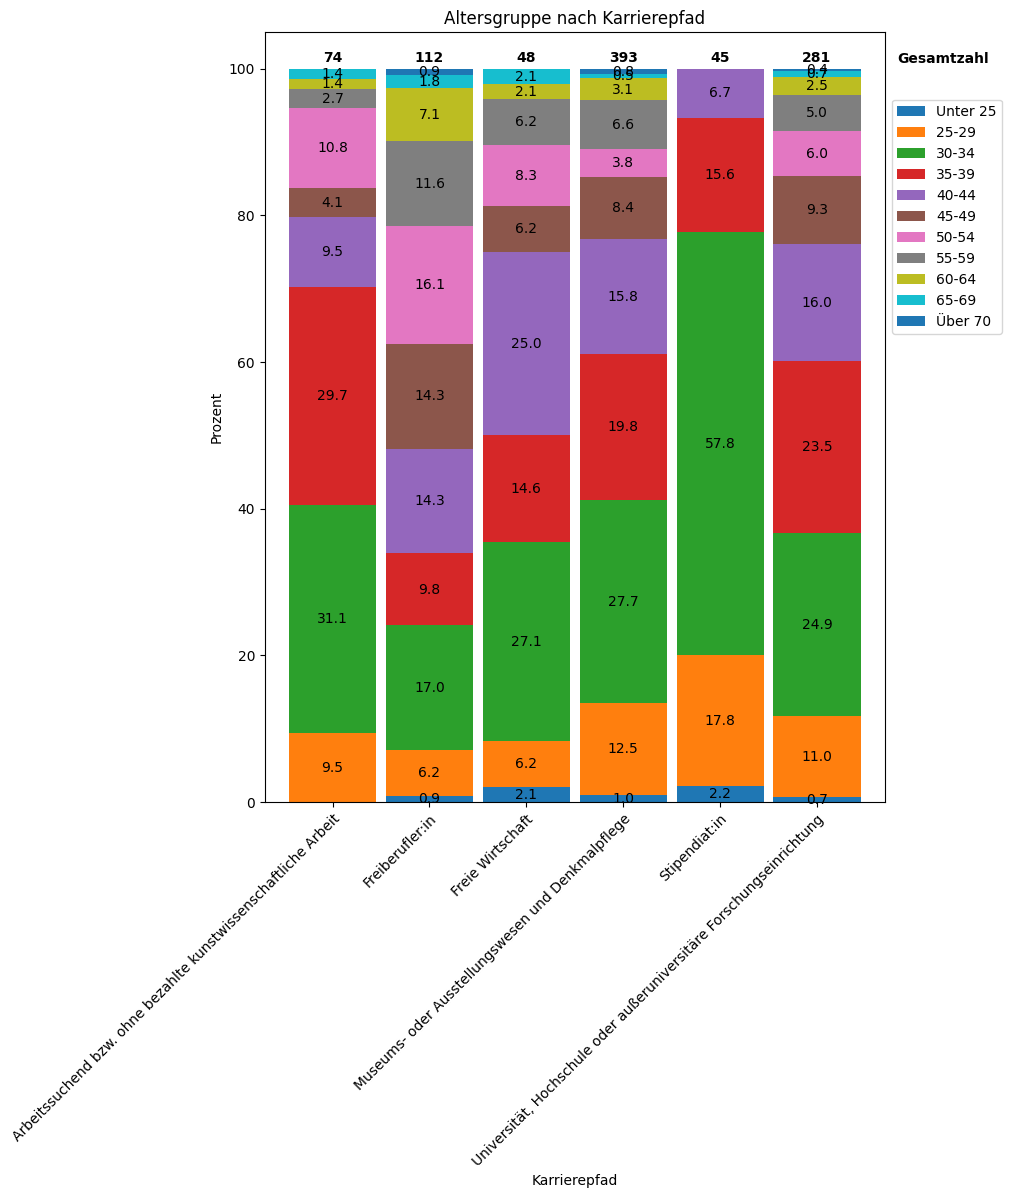

In [303]:
ax = aggregated_df[ls_perc_columns].plot(kind='bar', 
                        stacked=True, 
                        figsize=(8, 10),                                                                                        
                        #rot=45,
                        ylabel='Prozent',
                        xlabel='Karrierepfad',
                        width=0.9,
                        title='Altersgruppe nach Karrierepfad'
                        )

# add percentage labels into the bars
for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
    
ax.set_xticklabels(aggregated_df['Career'], rotation=45, ha='right', rotation_mode='anchor')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.76), labels=decoded_age_levels)

#add total values of entries above bar
y_offset = 4
for i, total in enumerate(aggregated_df['totals']):
    ax.text(aggregated_df['totals'].index[i], y= 101, s = total, ha='center',
    weight='bold')

ax.text(1.02, 0.975, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')

In [304]:
fig = ax.get_figure()
fig.savefig('../reports/figures/AP_04_Pfad_vs_Alter.png', bbox_inches='tight', dpi=300)

* Karrierepfad vs Geschlecht
* Karrierepfad vs Kinder